# Etapa 1: A Fase de Experimentação (O Notebook)

> Testes com modelos de detecção, rastreamento e extração de dados em notebooks.


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
✅ Bibliotecas e dependências importadas com sucesso.
✅ Parâmetros de configuração inicializados.

Carregando modelo 'yolov8s.pt'...
Abrindo vídeo: '..\data\videos_publicos\pessoas_terminal.mp4'...


Analisando Trajetórias: 100%|██████████| 429/429 [01:00<00:00,  7.10it/s]


✅ Análise e extração de trajetórias concluída.
Gerando o mapa de calor de fluxo...
✅ Mapa de calor finalizado.

-> Imagem salva com sucesso em: '..\output\heatmaps\pessoas_terminal_flow_heatmap.png'


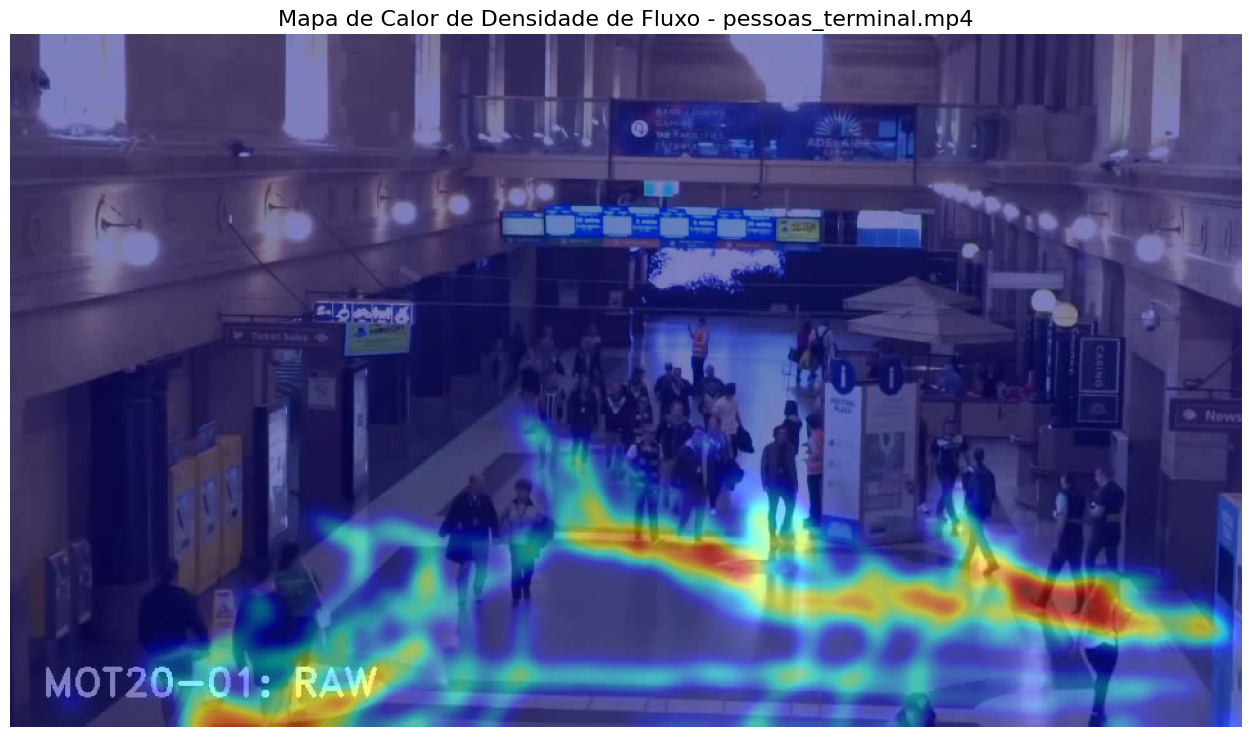


--- FIM DA ETAPA DE EXPERIMENTAÇÃO ---


In [15]:
# ==================================================================================================
# PROJETO: GERADOR DE MAPAS DE CALOR PARA OTIMIZAÇÃO DE ESPAÇOS PÚBLICOS
# MÓDULO: NOTEBOOK DE EXPERIMENTAÇÃO E VALIDAÇÃO DE LÓGICA
# ETAPA 1: A FASE DE EXPERIMENTAÇÃO (PROVA DE CONCEITO) > MAPA DE CALOR DE DENSIDADE DE FLUXO
# VERSÃO: 7.2
#
# OBJETIVO: Este notebook servirá como a prova de conceito para a metodologia de geração 
#           de mapas de calor baseados em densidade de fluxo. A lógica validada aqui 
#           será a base para os módulos de produção da aplicação final.
#  
#           Assim, servirá para validar a capacidade de rastrear indivíduos em um vídeo e gerar
#           um gráfico de dados de trajetória puro, filtrando ruído e destacando
#           os principais padrões de fluxo.
# ==================================================================================================

# --------------------------------------------------------------------------------------------------
# 1. INSTALAÇÃO DE DEPENDÊNCIAS E IMPORTAÇÃO DE MÓDULOS
# --------------------------------------------------------------------------------------------------
# Assegura que as bibliotecas necessárias estão disponíveis no ambiente de execução.
# O argumento '-q' (quiet) minimiza o output da instalação.
%pip install ultralytics matplotlib tqdm -q

# Importações das bibliotecas que serão utilizadas 
import cv2
import numpy as np
from ultralytics import YOLO
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import defaultdict

print("✅ Bibliotecas e dependências importadas com sucesso.")

# --------------------------------------------------------------------------------------------------
# 2. CONFIGURAÇÃO CENTRALIZADA DO EXPERIMENTO
# --------------------------------------------------------------------------------------------------
# Centralizar parâmetros em um único bloco é uma boa prática para facilitar a
# experimentação e a manutenção do código.

# --- Definição de Caminhos (Paths) ---
# Utiliza caminhos relativos para garantir a portabilidade do projeto entre diferentes sistemas.
# O '..' navega para o diretório raiz do projeto a partir da pasta 'notebooks'.
BASE_DIR = '..'
# Parâmetro de entrada principal: o nome do arquivo de vídeo a ser analisado.
# !! IMPORTANTE: Coloque aqui o nome do seu vídeo de teste.
VIDEO_FILENAME = 'pessoas_terminal.mp4'
VIDEO_PATH = os.path.join(BASE_DIR, 'data', 'videos_publicos', VIDEO_FILENAME)
# Diretório para salvar os artefatos gerados.
OUTPUT_DIR = os.path.join(BASE_DIR, 'output', 'heatmaps')
os.makedirs(OUTPUT_DIR, exist_ok=True) # Garante a existência do diretório de saída.

# --- Configurações do Modelo de Rastreamento (YOLOv8) ---
# JUSTIFICATIVA: yolov8s.pt ('small') é selecionado como um trade-off otimizado entre
# a precisão na detecção de objetos pequenos e a performance computacional.
MODEL_NAME = 'yolov8s.pt'
# Limiar de confiança para que uma detecção seja considerada válida pelo rastreador.
CONF_THRESHOLD = 0.3
# Filtra as detecções para incluir apenas a classe 'person' (ID 0 no dataset COCO).
TRACKING_CLASSES = [0] # Pessoas

# --- Configurações de Performance ---
# Define o intervalo de processamento de frames para otimizar a velocidade.
# FRAME_SKIP = 1 significa que 1 a cada 2 frames será processado.
FRAME_SKIP = 1

# --- Parâmetros de Visualização do Mapa de Calor de Fluxo ---
# Espessura base, em pixels, para renderizar as linhas de trajetória.
LINE_THICKNESS = 2
# O tamanho do kernel do filtro Gaussiano. Este é o parâmetro primário para controlar
# a difusão e a suavidade do "calor" emanado das trajetórias. Deve ser um valor ímpar.
GAUSSIAN_KERNEL_SIZE = (51, 51)
# Colormap a ser aplicado sobre o mapa de intensidade. cv2.COLORMAP_JET é utilizado
# para replicar o gradiente visual (azul-verde-amarelo-vermelho) da imagem de referência.
COLOR_MAP = cv2.COLORMAP_JET
# Define a opacidade da camada do mapa de calor quando sobreposta ao frame de fundo.
HEATMAP_ALPHA = 0.5

print("✅ Parâmetros de configuração inicializados.")

# --------------------------------------------------------------------------------------------------
# 3. LÓGICA PRINCIPAL: RASTREAMENTO E GERAÇÃO DO MAPA DE FLUXO
# --------------------------------------------------------------------------------------------------

# --- Carregamento do Modelo e do Vídeo ---
print(f"\nCarregando modelo '{MODEL_NAME}'...")
model = YOLO(MODEL_NAME)
print(f"Abrindo vídeo: '{VIDEO_PATH}'...")
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise IOError(f"ERRO: Falha ao abrir o arquivo de vídeo. Verifique o caminho do vídeo: '{VIDEO_PATH}'")

# Extrai metadados do vídeo para uso posterior.
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
background_frame = None # Variável para armazenar o primeiro frame válido como fundo.

# --- Loop de Rastreamento e Extração de Dados ---
# A estrutura de dados defaultdict(list) é utilizada para armazenar as sequências de
# coordenadas (trajetórias) para cada ID de objeto rastreado.
track_history = defaultdict(list)
# tqdm é utilizado para renderizar uma barra de progresso no console, melhorando a UX.
with tqdm(total=total_frames, desc="Analisando Trajetórias") as pbar:
    frame_index = 0
    while cap.isOpened():
        success, frame = cap.read()
        if not success: break
        if background_frame is None: background_frame = frame.copy() # Pega o primeiro frame para o fundo

        if frame_index % (FRAME_SKIP + 1) == 0:
            # Executa o rastreador YOLO no frame atual.
            results = model.track(frame, persist=True, classes=TRACKING_CLASSES, conf=CONF_THRESHOLD, verbose=False)
            if results[0].boxes.id is not None:
                boxes = results[0].boxes.xywh.cpu()
                track_ids = results[0].boxes.id.int().cpu().tolist()
                for box, track_id in zip(boxes, track_ids):
                    # O ponto de referência da trajetória é o centro inferior da caixa delimitadora.
                    center_point = (int(box[0]), int(box[1] + box[3] / 2))
                    track_history[track_id].append(center_point)
        frame_index += 1
        pbar.update(1)
cap.release()
print("✅ Análise e extração de trajetórias concluída.")

# --- GERAÇÃO DO MAPA DE CALOR DE DENSIDADE DE FLUXO ---
if background_frame is None:
    raise ValueError("Processamento abortado: nenhum frame válido foi lido do vídeo.")

print("Gerando o mapa de calor de fluxo...")

# PASSO 1: DESENHAR TRAJETÓRIAS
# Inicializa um canvas de canal único (escala de cinza) para desenhar as trajetórias.
trajectory_canvas = np.zeros((frame_height, frame_width), dtype=np.float32)
# Itera sobre todas as trajetórias coletadas e as desenha no canvas.
for path in track_history.values():
    for i in range(len(path) - 1):
        cv2.line(trajectory_canvas, path[i], path[i+1], color=1, thickness=LINE_THICKNESS)

# PASSO 2: APLICAR BLUR PARA CRIAR O "CALOR"
# O filtro Gaussiano é aplicado ao canvas das linhas. Onde as linhas se sobrepõem,
# a intensidade dos pixels é maior, resultando em "pontos quentes" após o blur.
# Esta é a técnica central para visualizar a densidade do fluxo.
trajectory_canvas = cv2.GaussianBlur(trajectory_canvas, GAUSSIAN_KERNEL_SIZE, 0)

# PASSO 3: NORMALIZAR E COLORIR
# Normaliza o mapa de intensidade para o intervalo [0, 255] para que possa ser mapeado para cores.
heatmap_normalized = cv2.normalize(trajectory_canvas, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# Aplica o colormap para converter a intensidade em uma imagem colorida (BGR).
heatmap_colored = cv2.applyColorMap(heatmap_normalized, COLOR_MAP)

# PASSO 4: SOBREPOR AO VÍDEO COM TRANSPARÊNCIA
# Realiza a sobreposição do mapa de calor com o frame de fundo usando uma combinação linear
# ponderada (alpha blending) para criar o efeito de transparência.
blended_image = cv2.addWeighted(background_frame, 1 - HEATMAP_ALPHA, heatmap_colored, HEATMAP_ALPHA, 0)

print("✅ Mapa de calor finalizado.")

# --------------------------------------------------------------------------------------------------
# 4. EXIBIÇÃO E SALVAMENTO DO RESULTADO
# --------------------------------------------------------------------------------------------------

# --- Salvamento do Arquivo ---
output_filename = f"{os.path.splitext(VIDEO_FILENAME)[0]}_flow_heatmap.png"
output_path = os.path.join(OUTPUT_DIR, output_filename)
cv2.imwrite(output_path, blended_image)
print(f"\n-> Imagem salva com sucesso em: '{output_path}'")

# --- Exibição no Jupyter Notebook ---
# É necessário converter o espaço de cores de BGR (padrão do OpenCV) para RGB
# (padrão do Matplotlib) para uma exibição correta das cores.
final_image_rgb = cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB)

# Utiliza Matplotlib para renderizar a imagem de saída de forma controlada.
plt.figure(figsize=(16, 9))
plt.imshow(final_image_rgb)
plt.title(f"Mapa de Calor de Densidade de Fluxo - {VIDEO_FILENAME}", fontsize=16)
plt.axis('off')
plt.show()

print("\n--- FIM DA ETAPA DE EXPERIMENTAÇÃO ---")


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Bibliotecas e dependências importadas.
✅ Parâmetros de configuração inicializados.


Analisando e Rastreando: 100%|██████████| 341/341 [00:56<00:00,  6.06it/s]


✅ Rastreamento concluído.

--- Parâmetros Adaptativos Calculados ---
Altura Média da Detecção: 143.91 pixels
-> Espessura da Linha: 7 pixels
-> Kernel Gaussiano: (143, 143)
---------------------------------------
✅ Mapa de calor adaptativo gerado.

-> Artefato visual salvo em: '..\output\heatmaps\pessoas_adaptive_heatmap.png'


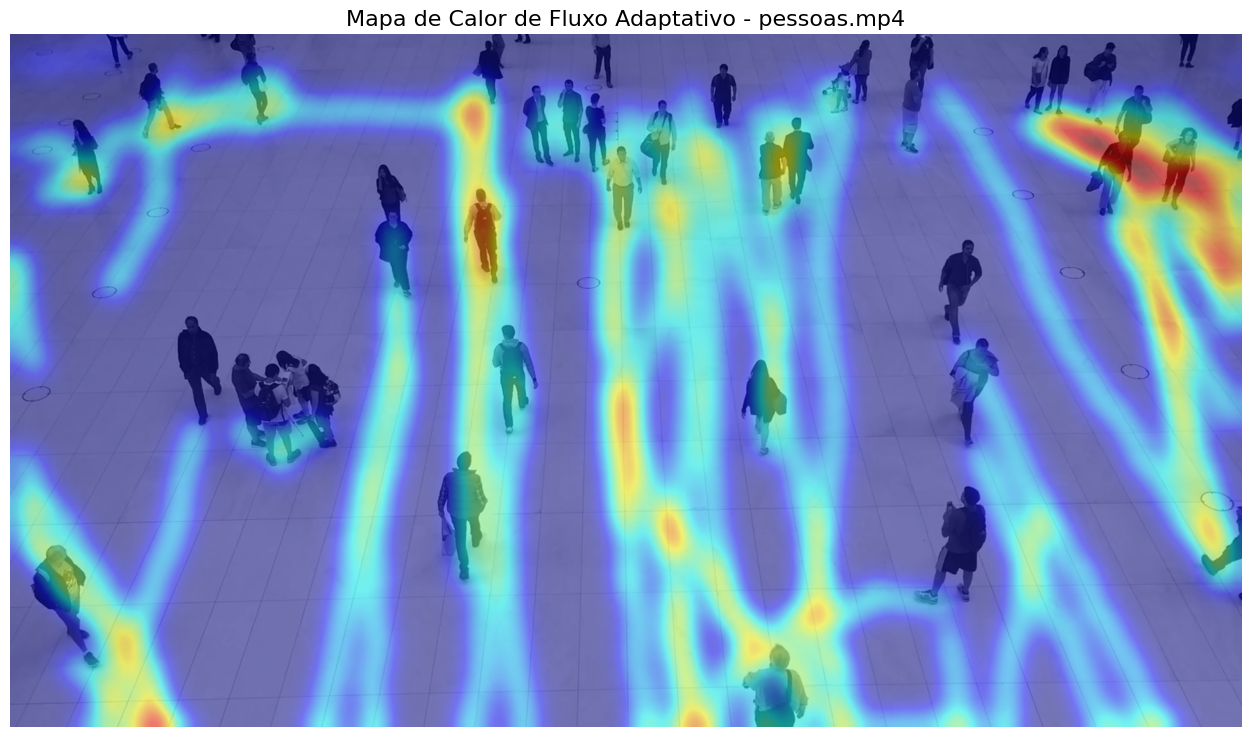


--- FIM DA ETAPA DE EXPERIMENTAÇÃO ---


In [20]:
# ==================================================================================================
# PROJETO: GERADOR DE MAPAS DE CALOR PARA OTIMIZAÇÃO DE ESPAÇOS PÚBLICOS
# MÓDULO: NOTEBOOK DE EXPERIMENTAÇÃO FINAL (PRONTO PARA REATORAÇÃO)
# VERSÃO: 8.1 - CORREÇÃO DO MÉTODO isOpened()
#
# DESCRIÇÃO: Esta versão implementa parâmetros de visualização adaptativos. A espessura
#            da linha e o tamanho do blur se ajustam automaticamente à escala dos objetos
#            detectados no vídeo, garantindo resultados consistentes em diferentes cenários.
#            O código está estruturado em funções para facilitar a transição para a Etapa 2.
# ==================================================================================================

# --------------------------------------------------------------------------------------------------
# 1. INSTALAÇÃO DE DEPENDÊNCIAS E IMPORTAÇÃO DE MÓDULOS
# --------------------------------------------------------------------------------------------------
!pip install ultralytics matplotlib tqdm -q

import cv2
import numpy as np
from ultralytics import YOLO
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import defaultdict
import math

print("✅ Bibliotecas e dependências importadas.")

# --------------------------------------------------------------------------------------------------
# 2. BLOCO DE CONFIGURAÇÃO CENTRALIZADA
# --------------------------------------------------------------------------------------------------

# --- Definição de Caminhos (Paths) ---
BASE_DIR = '..'
VIDEO_FILENAME = 'pessoas.mp4'
VIDEO_PATH = os.path.join(BASE_DIR, 'data', 'videos_publicos', VIDEO_FILENAME)
OUTPUT_DIR = os.path.join(BASE_DIR, 'output', 'heatmaps')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Configurações do Modelo de Rastreamento ---
MODEL_NAME = 'yolov8s.pt'
CONF_THRESHOLD = 0.3
TRACKING_CLASSES = [0]
FRAME_SKIP = 1

# --- Parâmetros de Visualização (FATORES ADAPTATIVOS) ---
ADAPTIVE_LINE_FACTOR = 0.05
ADAPTIVE_BLUR_FACTOR = 1.0
HEATMAP_ALPHA = 0.5
COLOR_MAP = cv2.COLORMAP_JET

print("✅ Parâmetros de configuração inicializados.")

# --------------------------------------------------------------------------------------------------
# 3. FUNÇÕES MODULARIZADAS (PRONTAS PARA SEREM ARQUIVOS .PY)
# --------------------------------------------------------------------------------------------------

def process_video_and_track(video_path, model, frame_skip, conf_threshold):
    """
    Processa o vídeo para rastrear objetos e extrair dados brutos.
    Esta função será a base para o módulo 'tracker.py'.

    Retorna:
        - track_history (dict): Dicionário com as trajetórias.
        - background_frame (np.array): Primeiro frame do vídeo para usar como fundo.
        - avg_detection_height (float): Altura média das detecções, para a lógica adaptativa.
    """
    cap = cv2.VideoCapture(video_path)
    # CORREÇÃO APLICADA AQUI: O método correto é isOpened() com 'O' maiúsculo.
    if not cap.isOpened():
        raise IOError(f"ERRO: Falha ao abrir o arquivo de vídeo: {video_path}")

    track_history = defaultdict(list)
    detection_heights = []
    background_frame = None
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    with tqdm(total=total_frames, desc="Analisando e Rastreando") as pbar:
        frame_index = 0
        # CORREÇÃO APLICADA AQUI: O método correto é isOpened() com 'O' maiúsculo.
        while cap.isOpened():
            success, frame = cap.read()
            if not success: break
            if background_frame is None: background_frame = frame.copy()

            if frame_index % (frame_skip + 1) == 0:
                results = model.track(frame, persist=True, classes=TRACKING_CLASSES, conf=conf_threshold, verbose=False)
                if results[0].boxes.id is not None:
                    boxes_wh = results[0].boxes.xywh.cpu()
                    track_ids = results[0].boxes.id.int().cpu().tolist()
                    for box, track_id in zip(boxes_wh, track_ids):
                        center_point = (int(box[0]), int(box[1] + box[3] / 2))
                        track_history[track_id].append(center_point)
                        detection_heights.append(box[3])
            frame_index += 1
            pbar.update(1)
            
    cap.release()
    
    avg_detection_height = np.mean(detection_heights) if detection_heights else 30.0
    
    print("✅ Rastreamento concluído.")
    return track_history, background_frame, avg_detection_height


def generate_adaptive_flow_heatmap(background_frame, track_history, avg_height, line_factor, blur_factor):
    """
    Gera o mapa de calor de fluxo com parâmetros visuais adaptativos.
    Esta função será a base para o módulo 'heatmap_generator.py'.

    Retorna:
        - blended_image (np.array): A imagem final com o mapa de calor sobreposto.
    """
    if background_frame is None:
        raise ValueError("Frame de fundo não pode ser nulo.")

    # --- Cálculo dos Parâmetros Adaptativos ---
    line_thickness = max(1, int(avg_height * line_factor))
    kernel_size = max(1, int(avg_height * blur_factor))
    if kernel_size % 2 == 0: kernel_size += 1
    gaussian_kernel = (kernel_size, kernel_size)
    
    print("\n--- Parâmetros Adaptativos Calculados ---")
    print(f"Altura Média da Detecção: {avg_height:.2f} pixels")
    print(f"-> Espessura da Linha: {line_thickness} pixels")
    print(f"-> Kernel Gaussiano: {gaussian_kernel}")
    print("---------------------------------------")

    # Lógica de Geração do Heatmap
    frame_height, frame_width, _ = background_frame.shape
    trajectory_canvas = np.zeros((frame_height, frame_width), dtype=np.float32)

    for path in track_history.values():
        for i in range(len(path) - 1):
            cv2.line(trajectory_canvas, path[i], path[i+1], 1.0, line_thickness)

    trajectory_canvas = cv2.GaussianBlur(trajectory_canvas, gaussian_kernel, 0)
    
    heatmap_normalized = cv2.normalize(trajectory_canvas, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    heatmap_colored = cv2.applyColorMap(heatmap_normalized, COLOR_MAP)

    blended_image = cv2.addWeighted(background_frame, 1 - HEATMAP_ALPHA, heatmap_colored, HEATMAP_ALPHA, 0)
    
    print("✅ Mapa de calor adaptativo gerado.")
    return blended_image


# --------------------------------------------------------------------------------------------------
# 4. ORQUESTRAÇÃO E EXECUÇÃO DO EXPERIMENTO
# --------------------------------------------------------------------------------------------------

def run_experiment():
    """
    Função principal que orquestra todo o processo de análise.
    Esta lógica será a base para o 'app.py'.
    """
    model = YOLO(MODEL_NAME)

    track_history, background_frame, avg_height = process_video_and_track(
        VIDEO_PATH, model, FRAME_SKIP, CONF_THRESHOLD
    )

    final_image = generate_adaptive_flow_heatmap(
        background_frame, track_history, avg_height, ADAPTIVE_LINE_FACTOR, ADAPTIVE_BLUR_FACTOR
    )

    output_filename = f"{os.path.splitext(VIDEO_FILENAME)[0]}_adaptive_heatmap.png"
    output_path = os.path.join(OUTPUT_DIR, output_filename)
    cv2.imwrite(output_path, final_image)
    print(f"\n-> Artefato visual salvo em: '{output_path}'")

    final_image_rgb = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16, 9))
    plt.imshow(final_image_rgb)
    plt.title(f"Mapa de Calor de Fluxo Adaptativo - {VIDEO_FILENAME}", fontsize=16)
    plt.axis('off')
    plt.show()

# Ponto de entrada para executar o experimento.
if __name__ == '__main__':
    run_experiment()
    print("\n--- FIM DA ETAPA DE EXPERIMENTAÇÃO ---")


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Bibliotecas e dependências importadas.
✅ Parâmetros de configuração inicializados.


Processando Vídeo (Passagem Única): 100%|██████████| 429/429 [02:35<00:00,  2.77it/s]


✅ Processamento de passagem única concluído.

-> Vídeo de rastreamento salvo em: '..\output\tracked_videos\pessoas_terminal_tracked.mp4'
✅ Mapa de calor de fluxo gerado.
-> Imagem do mapa de calor salva em: '..\output\heatmaps\pessoas_terminal_flow_heatmap.png'


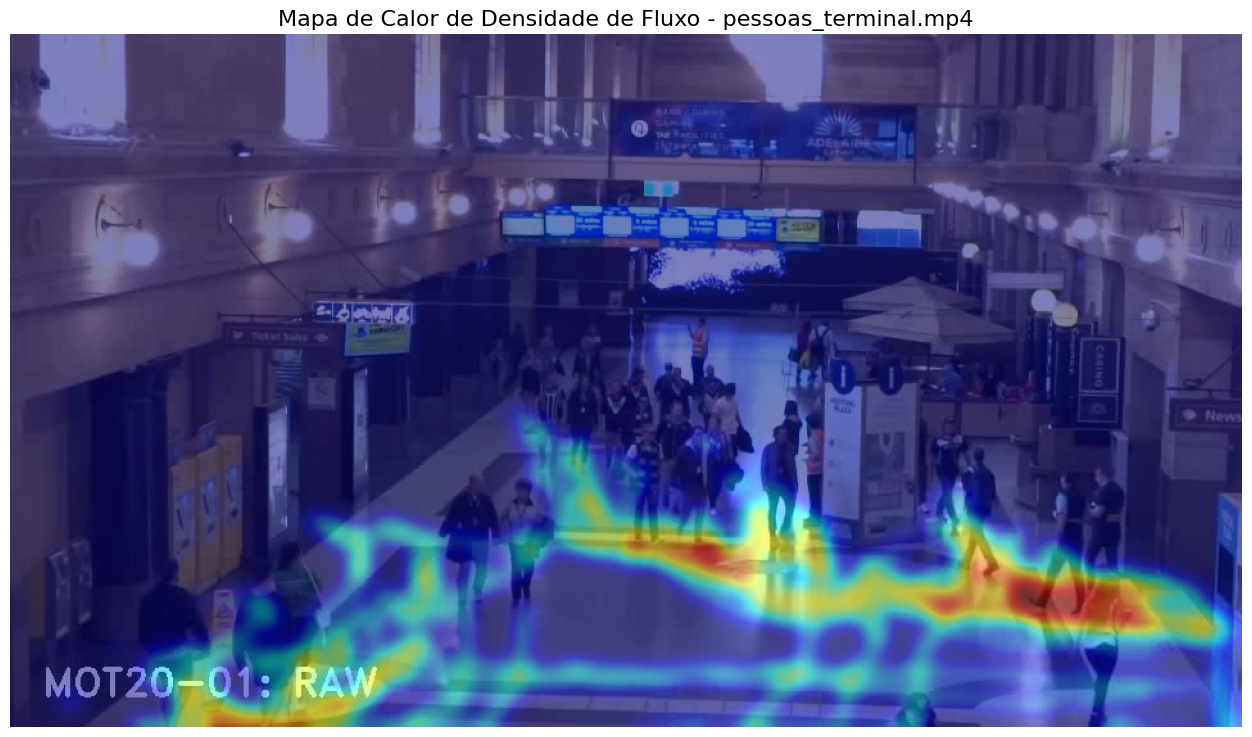


--- FIM DA ETAPA DE EXPERIMENTAÇÃO. TODOS OS ARTEFATOS FORAM GERADOS. ---


In [23]:
# ==================================================================================================
# PROJETO: GERADOR DE MAPAS DE CALOR PARA OTIMIZAÇÃO DE ESPAÇOS PÚBLICOS
# MÓDULO: NOTEBOOK DE EXPERIMENTAÇÃO FINAL (GERAÇÃO DE MÚLTIPLOS ARTEFATOS)
# VERSÃO: 9.0 - Final, Pronto para Refatoração
#
# DESCRIÇÃO: Esta versão final do notebook processa o vídeo de entrada em uma única
#            passagem para gerar dois produtos distintos:
#            1. Uma imagem estática com o mapa de calor de densidade de fluxo.
#            2. Um novo arquivo de vídeo com as trajetórias e IDs de rastreamento desenhados.
# ==================================================================================================

# --------------------------------------------------------------------------------------------------
# 1. INSTALAÇÃO DE DEPENDÊNCIAS E IMPORTAÇÃO DE MÓDULOS
# --------------------------------------------------------------------------------------------------
!pip install ultralytics matplotlib tqdm -q

import cv2
import numpy as np
from ultralytics import YOLO
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import defaultdict
import random

print("✅ Bibliotecas e dependências importadas.")

# --------------------------------------------------------------------------------------------------
# 2. BLOCO DE CONFIGURAÇÃO CENTRALIZADA
# --------------------------------------------------------------------------------------------------
# --- Definição de Caminhos (Paths) ---
BASE_DIR = '..'
VIDEO_FILENAME = 'pessoas_terminal.mp4' # Vídeo a ser analisado
VIDEO_PATH = os.path.join(BASE_DIR, 'data', 'videos_publicos', VIDEO_FILENAME)
# Diretório para salvar ambos os resultados
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'heatmaps'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'tracked_videos'), exist_ok=True)


# --- Configurações do Modelo e Rastreamento ---
MODEL_NAME = 'yolov8s.pt'
CONF_THRESHOLD = 0.3
TRACKING_CLASSES = [0]
FRAME_SKIP = 0 # Para gerar um vídeo fluido, processamos todos os frames.

# --- Parâmetros de Visualização do Mapa de Calor ---
LINE_THICKNESS_HEATMAP = 2
GAUSSIAN_KERNEL_SIZE = (51, 51)
HEATMAP_ALPHA = 0.5
COLOR_MAP = cv2.COLORMAP_JET

print("✅ Parâmetros de configuração inicializados.")

# --------------------------------------------------------------------------------------------------
# 3. FUNÇÕES MODULARIZADAS
# --------------------------------------------------------------------------------------------------

def draw_tracking_annotations(frame, boxes, track_ids, track_colors):
    """
    Desenha as anotações de rastreamento (caixas e IDs) em um frame.
    Garante que cada ID de trajetória tenha uma cor única e persistente.
    """
    for box, track_id in zip(boxes, track_ids):
        x1, y1, x2, y2 = map(int, box)
        
        # Atribui uma cor aleatória, porém consistente, para cada nova trajetória.
        if track_id not in track_colors:
            track_colors[track_id] = (random.randint(30, 255), random.randint(30, 255), random.randint(30, 255))
        color = track_colors[track_id]

        # Desenha a caixa delimitadora (bounding box).
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

        # Prepara e desenha o rótulo (label) com o ID da pessoa.
        label = f"ID: {track_id}"
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(frame, (x1, y1 - h - 10), (x1 + w + 5, y1), color, -1)
        cv2.putText(frame, label, (x1 + 5, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, lineType=cv2.LINE_AA)
    return frame


def process_video_and_generate_outputs(video_path, model, output_video_path, frame_skip, conf_threshold):
    """
    Processa o vídeo de entrada em uma única passagem, gerando o vídeo de rastreamento
    e coletando os dados para o mapa de calor simultaneamente.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"ERRO: Falha ao abrir o arquivo de vídeo: {video_path}")

    # Configuração do VideoWriter para salvar o vídeo de saída.
    w, h, fps = (int(cap.get(p)) for p in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec .mp4
    out_video = cv2.VideoWriter(output_video_path, fourcc, fps, (w, h))

    track_history = defaultdict(list)
    track_colors = {}
    first_frame = None
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    with tqdm(total=total_frames, desc="Processando Vídeo (Passagem Única)") as pbar:
        frame_index = 0
        while cap.isOpened():
            success, frame = cap.read()
            if not success: break
            if first_frame is None: first_frame = frame.copy()

            annotated_frame = frame.copy()

            if frame_index % (frame_skip + 1) == 0:
                results = model.track(frame, persist=True, classes=TRACKING_CLASSES, conf=conf_threshold, verbose=False)
                if results[0].boxes.id is not None:
                    # Extrai dados para ambas as tarefas.
                    boxes_xyxy = results[0].boxes.xyxy.cpu().numpy()
                    boxes_xywh = results[0].boxes.xywh.cpu()
                    track_ids = results[0].boxes.id.int().cpu().tolist()

                    # TAREFA 1: Desenha as anotações no frame para o vídeo de saída.
                    annotated_frame = draw_tracking_annotations(annotated_frame, boxes_xyxy, track_ids, track_colors)
                    
                    # TAREFA 2: Coleta os dados de trajetória para o mapa de calor.
                    for box, track_id in zip(boxes_xywh, track_ids):
                        center_point = (int(box[0]), int(box[1] + box[3] / 2))
                        track_history[track_id].append(center_point)
            
            # Escreve o frame (anotado ou original) no vídeo de saída.
            out_video.write(annotated_frame)
            frame_index += 1
            pbar.update(1)

    cap.release()
    out_video.release()
    
    print("✅ Processamento de passagem única concluído.")
    return track_history, first_frame


def generate_flow_heatmap(background_frame, track_history):
    """Gera o mapa de calor de fluxo a partir dos dados de trajetória coletados."""
    if background_frame is None: raise ValueError("Frame de fundo é nulo.")

    h, w, _ = background_frame.shape
    trajectory_canvas = np.zeros((h, w), dtype=np.float32)

    for path in track_history.values():
        for i in range(len(path) - 1):
            cv2.line(trajectory_canvas, path[i], path[i+1], 1.0, LINE_THICKNESS_HEATMAP)

    trajectory_canvas = cv2.GaussianBlur(trajectory_canvas, GAUSSIAN_KERNEL_SIZE, 0)
    heatmap_norm = cv2.normalize(trajectory_canvas, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    heatmap_color = cv2.applyColorMap(heatmap_norm, COLOR_MAP)

    blended_image = cv2.addWeighted(background_frame, 1 - HEATMAP_ALPHA, heatmap_color, HEATMAP_ALPHA, 0)
    print("✅ Mapa de calor de fluxo gerado.")
    return blended_image


# --------------------------------------------------------------------------------------------------
# 4. ORQUESTRAÇÃO E EXECUÇÃO DO EXPERIMENTO
# --------------------------------------------------------------------------------------------------

def run_full_analysis_pipeline():
    """
    Função principal que orquestra todo o processo e gera os artefatos finais.
    """
    # Define os nomes dos arquivos de saída
    base_filename = os.path.splitext(VIDEO_FILENAME)[0]
    output_heatmap_path = os.path.join(OUTPUT_DIR, 'heatmaps', f"{base_filename}_flow_heatmap.png")
    output_video_path = os.path.join(OUTPUT_DIR, 'tracked_videos', f"{base_filename}_tracked.mp4")

    # Carrega o modelo
    model = YOLO(MODEL_NAME)

    # Etapa 1: Processamento em passagem única.
    track_history, first_frame = process_video_and_generate_outputs(
        VIDEO_PATH, model, output_video_path, FRAME_SKIP, CONF_THRESHOLD
    )
    print(f"\n-> Vídeo de rastreamento salvo em: '{output_video_path}'")

    # Etapa 2: Geração do mapa de calor com os dados coletados.
    final_heatmap_image = generate_flow_heatmap(first_frame, track_history)
    
    # Etapa 3: Salvamento e exibição da imagem do mapa de calor.
    cv2.imwrite(output_heatmap_path, final_heatmap_image)
    print(f"-> Imagem do mapa de calor salva em: '{output_heatmap_path}'")

    # Exibe a imagem do mapa de calor no notebook para verificação.
    heatmap_rgb = cv2.cvtColor(final_heatmap_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16, 9))
    plt.imshow(heatmap_rgb)
    plt.title(f"Mapa de Calor de Densidade de Fluxo - {VIDEO_FILENAME}", fontsize=16)
    plt.axis('off')
    plt.show()

# Ponto de entrada para executar todo o pipeline.
if __name__ == '__main__':
    run_full_analysis_pipeline()
    print("\n--- FIM DA ETAPA DE EXPERIMENTAÇÃO. TODOS OS ARTEFATOS FORAM GERADOS. ---")